In [1]:
import utils.Encryption as cen
import utils.CustomModel as cm
import utils.DataPipeline as dp
import tensorflow as tf
from PIL import Image
import json
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

d:\ProgramData\Anaconda3\envs\isic\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
root_dir = "F:\\pps_paper\\dataset"
train_dir = f"{root_dir}\\train"
test_dir = f"{root_dir}\\test"
validation_dir = f"{root_dir}\\validation"

train_images = f"{root_dir}\\train\\DataE"
train_masks = f"{root_dir}\\train\\GroundTruth_1E"
test_images = f"{root_dir}\\test\\DataE"
test_masks = f"{root_dir}\\test\\GroundTruth_1E"
validation_images = f"{root_dir}\\validation\\DataE"
validation_masks = f"{root_dir}\\validation\\GroundTruth_1E"

In [3]:
train = dp.CustomDataset(train_dir).get_Dataset()
test = dp.CustomDataset(test_dir).get_Dataset()
validation = dp.CustomDataset(validation_dir).get_Dataset()

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [16]:
model = cm.CustomModel((256,256,3,))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=optimizer)

In [17]:
history = model.fit(train, validation_data=validation,batch_size=10,epochs=3)

Epoch 1/3
2000/2000 [==============================] - 36s 17ms/step - loss: 0.0012 - val_loss: 2.6631e-06
Epoch 2/3
2000/2000 [==============================] - 34s 17ms/step - loss: 2.9675e-06 - val_loss: 2.6631e-06
Epoch 3/3
2000/2000 [==============================] - 36s 18ms/step - loss: 2.9675e-06 - val_loss: 2.6631e-06


In [18]:
history.model.summary()

Model: "custom_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(10, 256, 256, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           multiple                  608       
_________________________________________________________________
conv2d_25 (Conv2D)           multiple                  1168      
_________________________________________________________________
max_pooling2d_12 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_26 (Conv2D)           multiple                  8224      
_________________________________________________________________
max_pooling2d_13 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_27 (Conv2D)           multiple               

<Figure size 432x288 with 0 Axes>

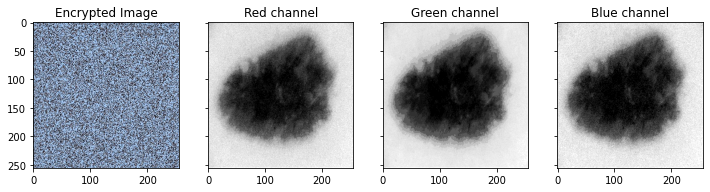

In [43]:
img = cv.imread('F:\\pps_paper\\dataset\\train\\DataE\\ISIC_0000000.jpg',1)
key = None
with open('key.json','r') as fp:
    key = json.load(fp)

Zb , Zg , Zr = cv.split(img)
Zb , Zg , Zr = Zb.flatten() , Zg.flatten() , Zr.flatten()  
# convert to np.float32
Zr = np.float32(Zr)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 20

ret,label,center=cv.kmeans(Zr,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
red = center[label.flatten()]
red = red.reshape((img.shape[0],img.shape[1]))

red = cen.unscramble(red,key)


# convert to np.float32
Zg = np.float32(Zg)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 20
ret,label,center=cv.kmeans(Zg,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
green = center[label.flatten()]
green = green.reshape((img.shape[0],img.shape[1]))

green = cen.unscramble(green,key)


# convert to np.float32
Zb = np.float32(Zb)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 20
ret,label,center=cv.kmeans(Zb,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
blue = center[label.flatten()]
blue = blue.reshape((img.shape[0],img.shape[1]))

blue = cen.unscramble(blue,key)


img = img[...,::-1]

plt.figure()
fig , ax = plt.subplots(1,4,sharey=True,figsize = (12,3))
ax[0].imshow(img)
ax[0].set_title('Encrypted Image')
ax[1].imshow(red,cmap='gray')
ax[1].set_title('Red channel')
ax[2].imshow(green,cmap='gray')
ax[2].set_title('Green channel')
ax[3].imshow(blue,cmap='gray')
ax[3].set_title('Blue channel')
plt.show()
